In [20]:
import glob
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import PandasTools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [21]:
path_to_library = '../FragmentLibrary'

# list of folders for each subpocket
folders = glob.glob(path_to_library+'/*')
subpockets = [folder[-2:] for folder in folders]
subpockets

['FP', 'B2', 'AP', 'SE', 'B1', 'GA']

In [22]:
# read data

data = pd.DataFrame()

rdkit_gen = rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5)

# iterate over subpockets
for i, folder in enumerate(folders):
    
    subpocket = subpockets[i]
    
    file = folder+'/'+subpocket+'.sdf' 
    df = pd.DataFrame()
    suppl = Chem.SDMolSupplier(file, removeHs=False)
        
    fragments = []
    fragments_2D = []
    fingerprints = []
    smiles = []

    for frag in suppl:
        
        # discard fragments without open bonds
        if '*' not in Chem.MolToSmiles(frag):
            continue
        frag_clean = Chem.DeleteSubstructs(frag, Chem.MolFromSmiles('*'))
        s = Chem.MolToSmiles(frag_clean)
        # remove duplicates based on smiles
        if s in smiles:
            continue
        smiles.append(s)
        fragments.append(frag)
        # 2D coordinates
        frag = Chem.RemoveHs(frag)
        tmp = AllChem.Compute2DCoords(frag)
        fragments_2D.append(frag)
        # fingerprint of fragment
        fingerprints.append(rdkit_gen.GetFingerprint(frag))
    
    df['Mol'] = fragments
    df['fragment'] = fragments_2D
    df['smiles'] = smiles
    df['fingerprint'] = fingerprints
    df['subpocket'] = subpocket
    
    data = data.append(df)
    
data = data.reset_index(drop=True)
data.shape

(3592, 5)

In [23]:
df_AP = data[data.subpocket=='AP']
df_FP = data[data.subpocket=='FP']
df_SE = data[data.subpocket=='SE']
df_GA = data[data.subpocket=='GA']
df_B1 = data[data.subpocket=='B1']
df_B2 = data[data.subpocket=='B2']

#### Clustering functions:

In [24]:
def analyze_clusters(clusters, subpocket, cutoff):
    
    # Give a short report about the numbers of clusters and their sizes
    num_clust_g1 = len([c for c in clusters if len(c) == 1])
    num_clust_g5 = len([c for c in clusters if len(c) > 5])
    num_clust_g25 = len([c for c in clusters if len(c) > 25])
    num_clust_g100 = len([c for c in clusters if len(c) > 100])

    print(subpocket)
    print("Threshold: ", cutoff)
    print("total # clusters: ", len(clusters))
    print("# clusters with only 1 compound: ", num_clust_g1)
    print("# clusters with >5 compounds: ", num_clust_g5)
    print("# clusters with >25 compounds: ", num_clust_g25)
    print("# clusters with >100 compounds: ", num_clust_g100)

    # Plot the size of the clusters
    fig = plt.figure(1, figsize=(8, 3))
    plt1 = plt.subplot(111)
    plt.axis([0, len(clusters), 0, len(clusters[0])+1])
    plt.xlabel('Cluster index', fontsize=20)
    plt.ylabel('Number of molecules', fontsize=20)
    plt.tick_params(labelsize=16)
    plt.title('Threshold: '+str('%3.1f' %cutoff), fontsize=10)
    plt1.bar(range(1, len(clusters)), [len(c) for c in clusters[:len(clusters)-1]], lw=0)
    plt.show()

    return None

In [25]:
# Input: Fingerprints and a threshold for the clustering
def ClusterFps(fps, cutoff=0.2):
    # Calculate Tanimoto distance matrix
    distance_matr = Tanimoto_distance_matrix(fps)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matr,len(fps),cutoff,isDistData=True)
    return clusters

In [26]:
# Calculate distance matrix for fingerprint list
def Tanimoto_distance_matrix(fp_list):
    fp_list = list(fp_list)
    dissimilarity_matrix = []
    for i in range(1,len(fp_list)):
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i],fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1-x for x in similarities])
    return dissimilarity_matrix

# Clustering:

### Adenine Pocket:

In [79]:
cutoff = 0.7

AP
Threshold:  0.7
total # clusters:  110
# clusters with only 1 compound:  42
# clusters with >5 compounds:  37
# clusters with >25 compounds:  8
# clusters with >100 compounds:  2


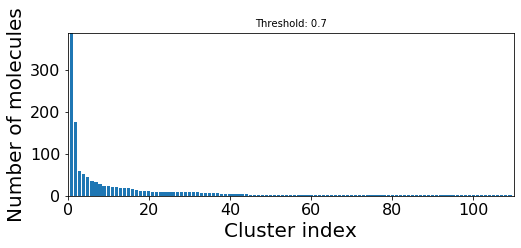

Total number of fragments:  1294


In [80]:
# investigate adenine pocket clusters
fps = df_AP.fingerprint
frags = list(df_AP.Mol)

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
analyze_clusters(clusters, 'AP', cutoff)

print('Total number of fragments: ', len(fps))

In [83]:
mols = [frags[i] for i in clusters[2]]
#Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols],  molsPerRow=8)

Cluster representatives: 


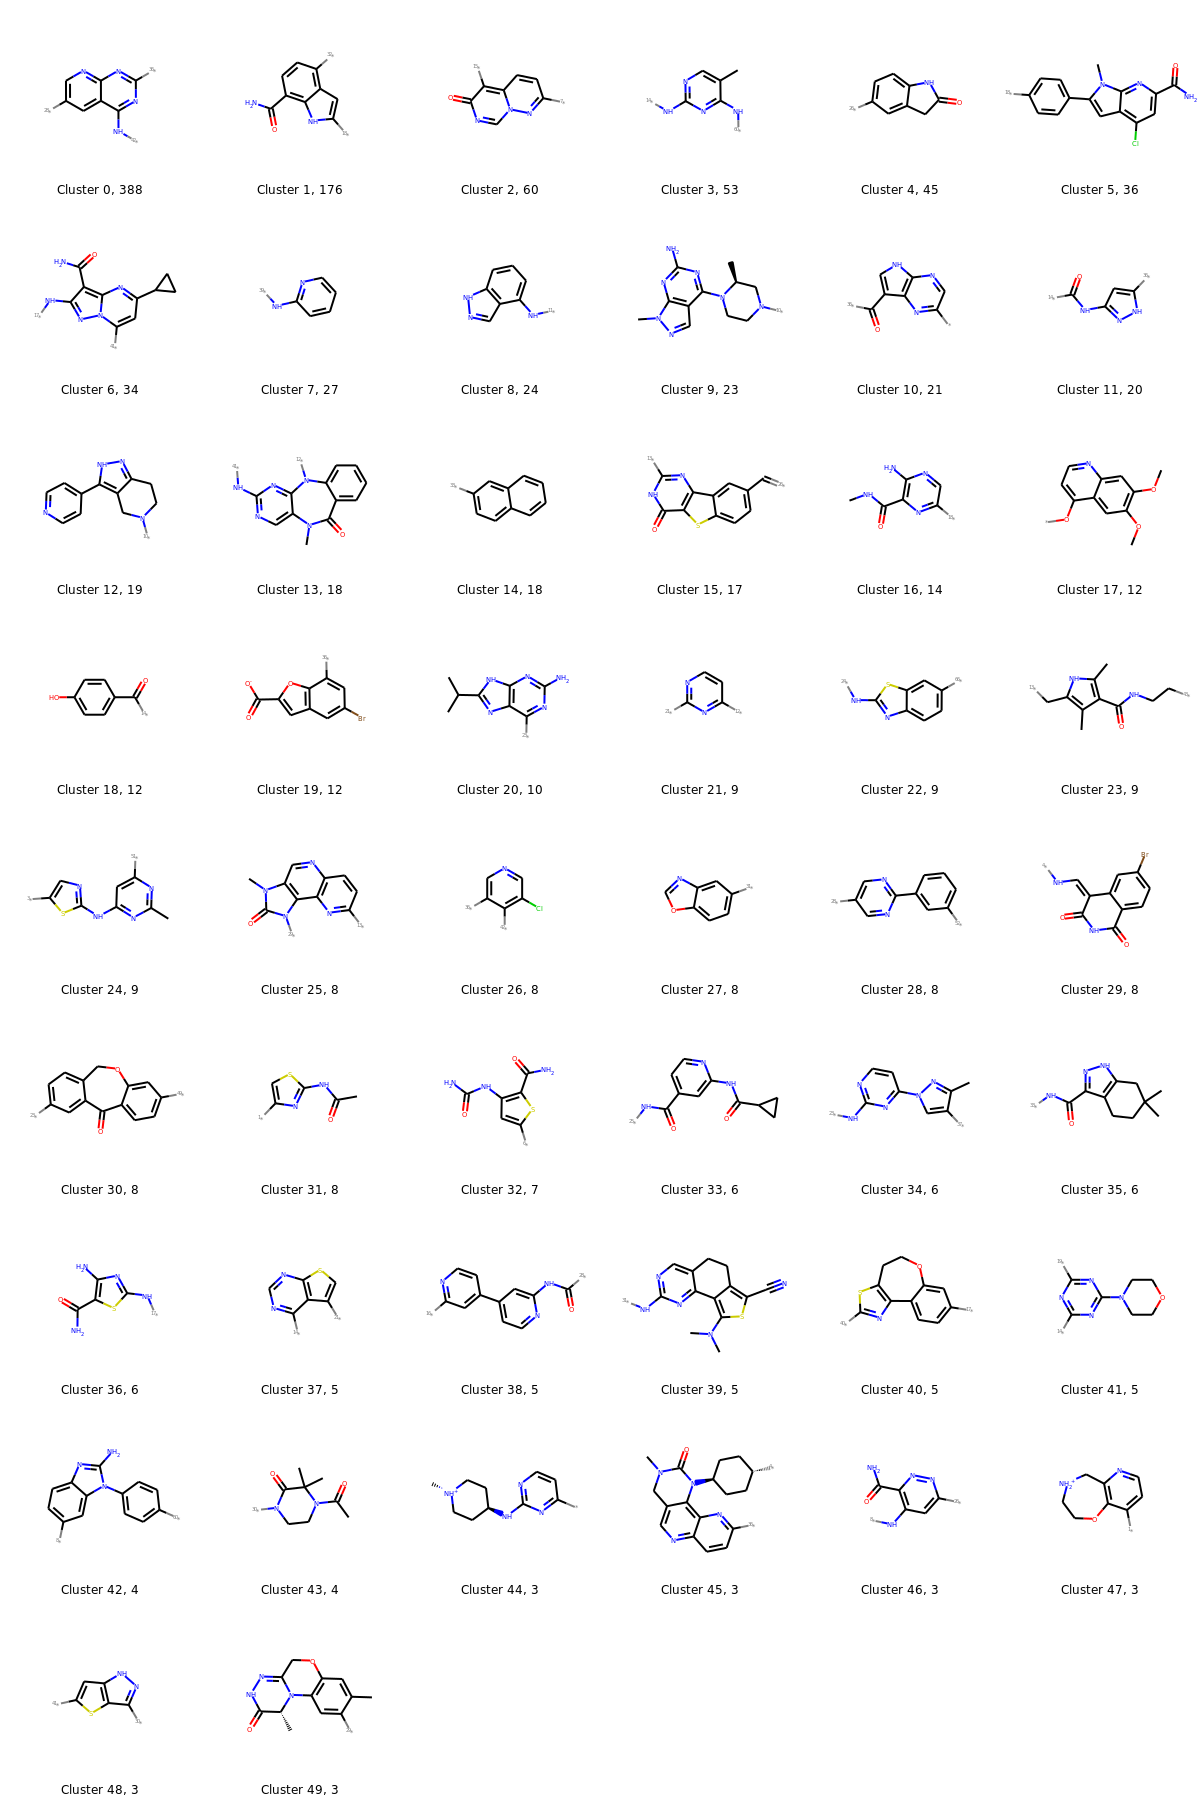

In [84]:
mols = []
legends = []
# plot cluster centroid for largest clusters
for i, cluster in enumerate(clusters):
    fragments = [frags[j] for j in cluster]
    # fragments.sort(key=mol_size)  # choose smallest fragment instead of centroid 
    mols.append(fragments[0])
    legend = 'Cluster '+str(i)+', '+str(len(cluster))
    legends.append(legend)
               
with open(path_to_library+'/AP/AP_reduced_'+str(cutoff)+'.sdf', 'w')as out_file:
    w = Chem.SDWriter(out_file)
    for mol in mols:
        w.write(mol)
    w.close()
    
print('Cluster representatives: ')     
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols], legends=legends, molsPerRow=6)

### Front Pocket:

FP
Threshold:  0.7
total # clusters:  123
# clusters with only 1 compound:  52
# clusters with >5 compounds:  32
# clusters with >25 compounds:  5
# clusters with >100 compounds:  2


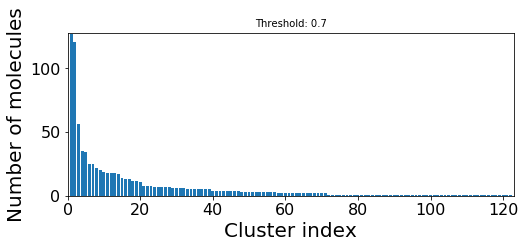

Total number of fragments:  890


In [85]:
# investigate adenine pocket clusters
fps = df_FP.fingerprint
frags = list(df_FP.Mol)

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
analyze_clusters(clusters, 'FP', cutoff)

print('Total number of fragments: ', len(frags))

In [87]:
mols = [frags[i] for i in clusters[0]]
# Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols],  molsPerRow=8)

Cluster representatives: 


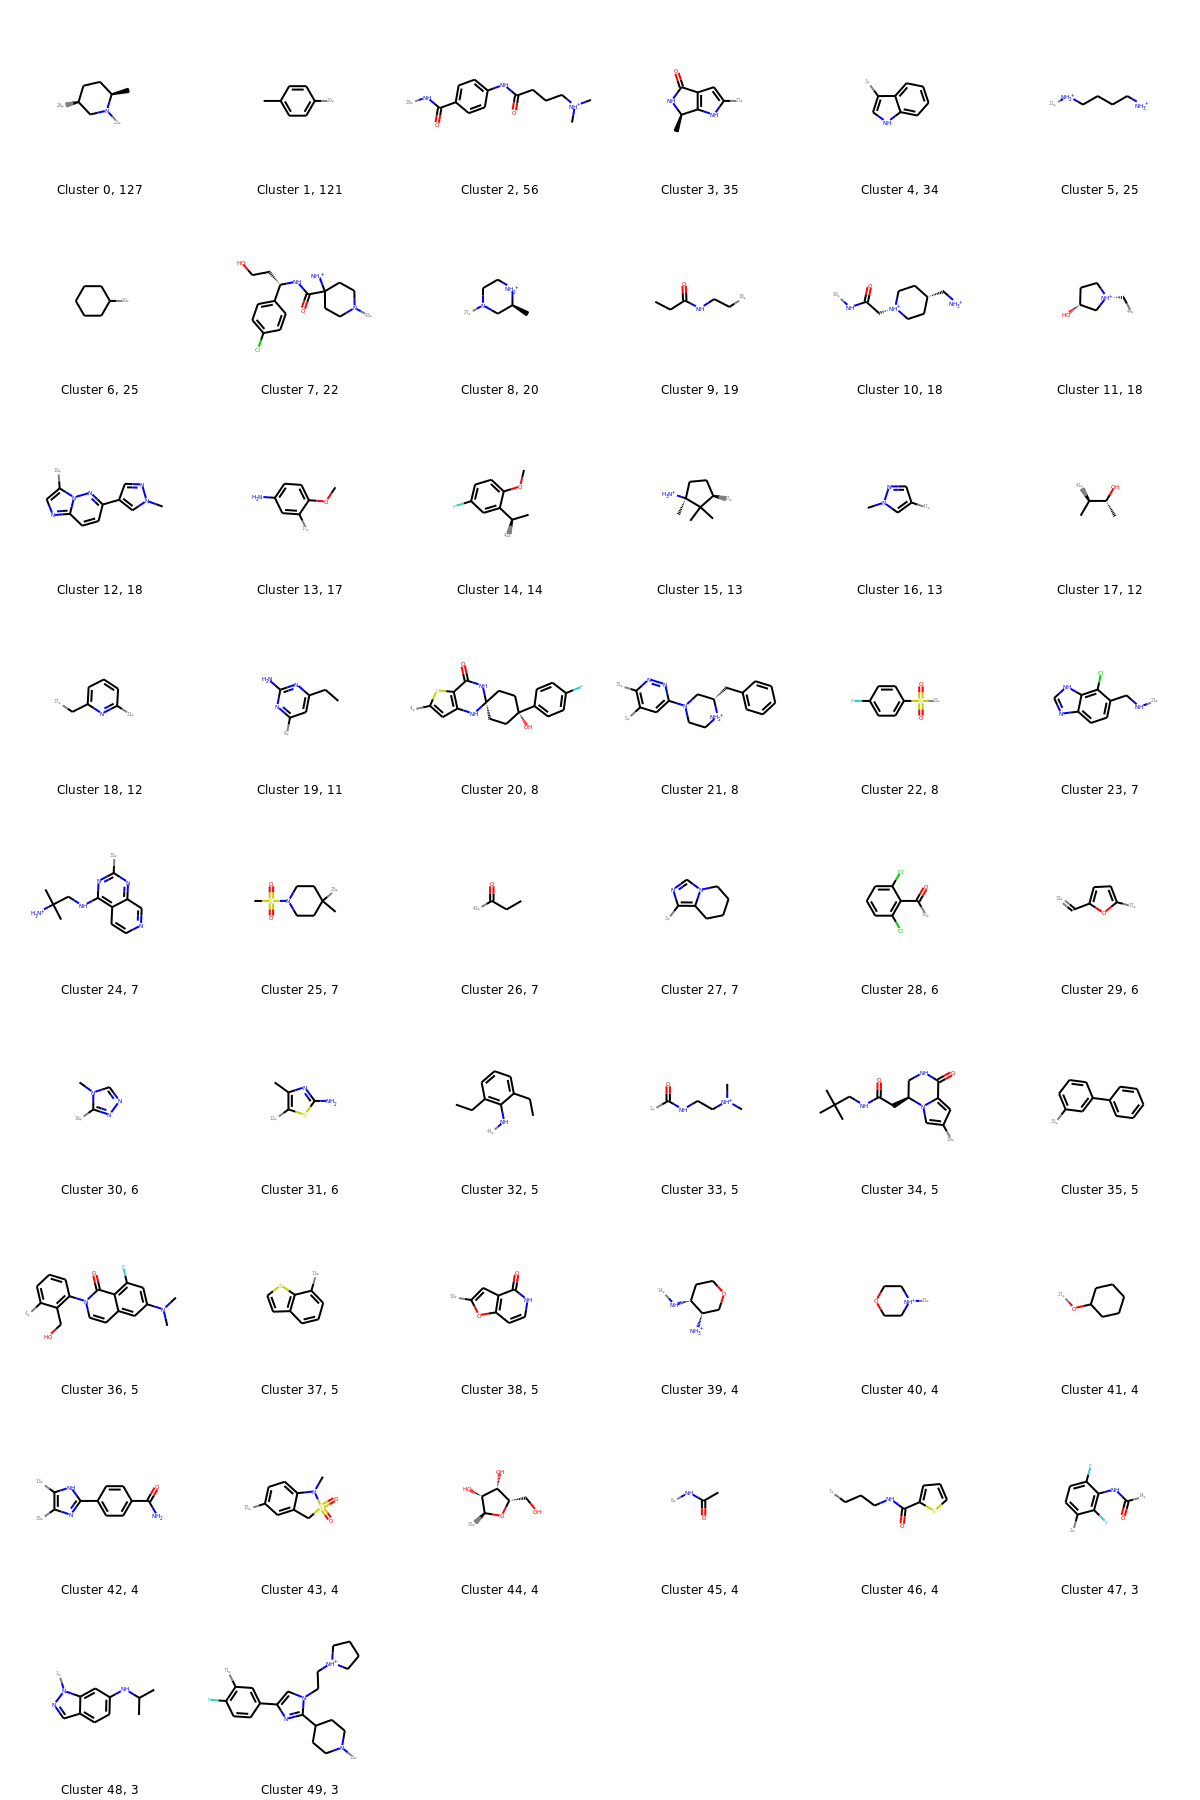

In [88]:
mols = []
legends = []
# plot cluster centroid for largest clusters
for i, cluster in enumerate(clusters):
    fragments = [frags[j] for j in cluster]
    # fragments.sort(key=mol_size)  # choose smallest fragment instead of centroid
    mols.append(fragments[0])
    legend = 'Cluster '+str(i)+', '+str(len(cluster))
    legends.append(legend)
               
with open(path_to_library+'/FP/FP_reduced_'+str(cutoff)+'.sdf', 'w')as out_file:
    w = Chem.SDWriter(out_file)
    for mol in mols:
        w.write(mol)
    w.close()
    
print('Cluster representatives: ')     
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols], legends=legends, molsPerRow=6)

### SE Pocket:

SE
Threshold:  0.7
total # clusters:  94
# clusters with only 1 compound:  43
# clusters with >5 compounds:  23
# clusters with >25 compounds:  7
# clusters with >100 compounds:  1


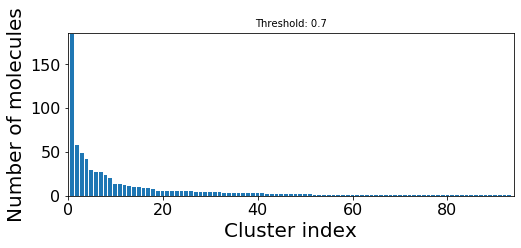

Total number of fragments:  715


In [89]:
# investigate adenine pocket clusters
fps = df_SE.fingerprint
frags = list(df_SE.Mol)

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
analyze_clusters(clusters, 'SE', cutoff)

print('Total number of fragments: ', len(frags))

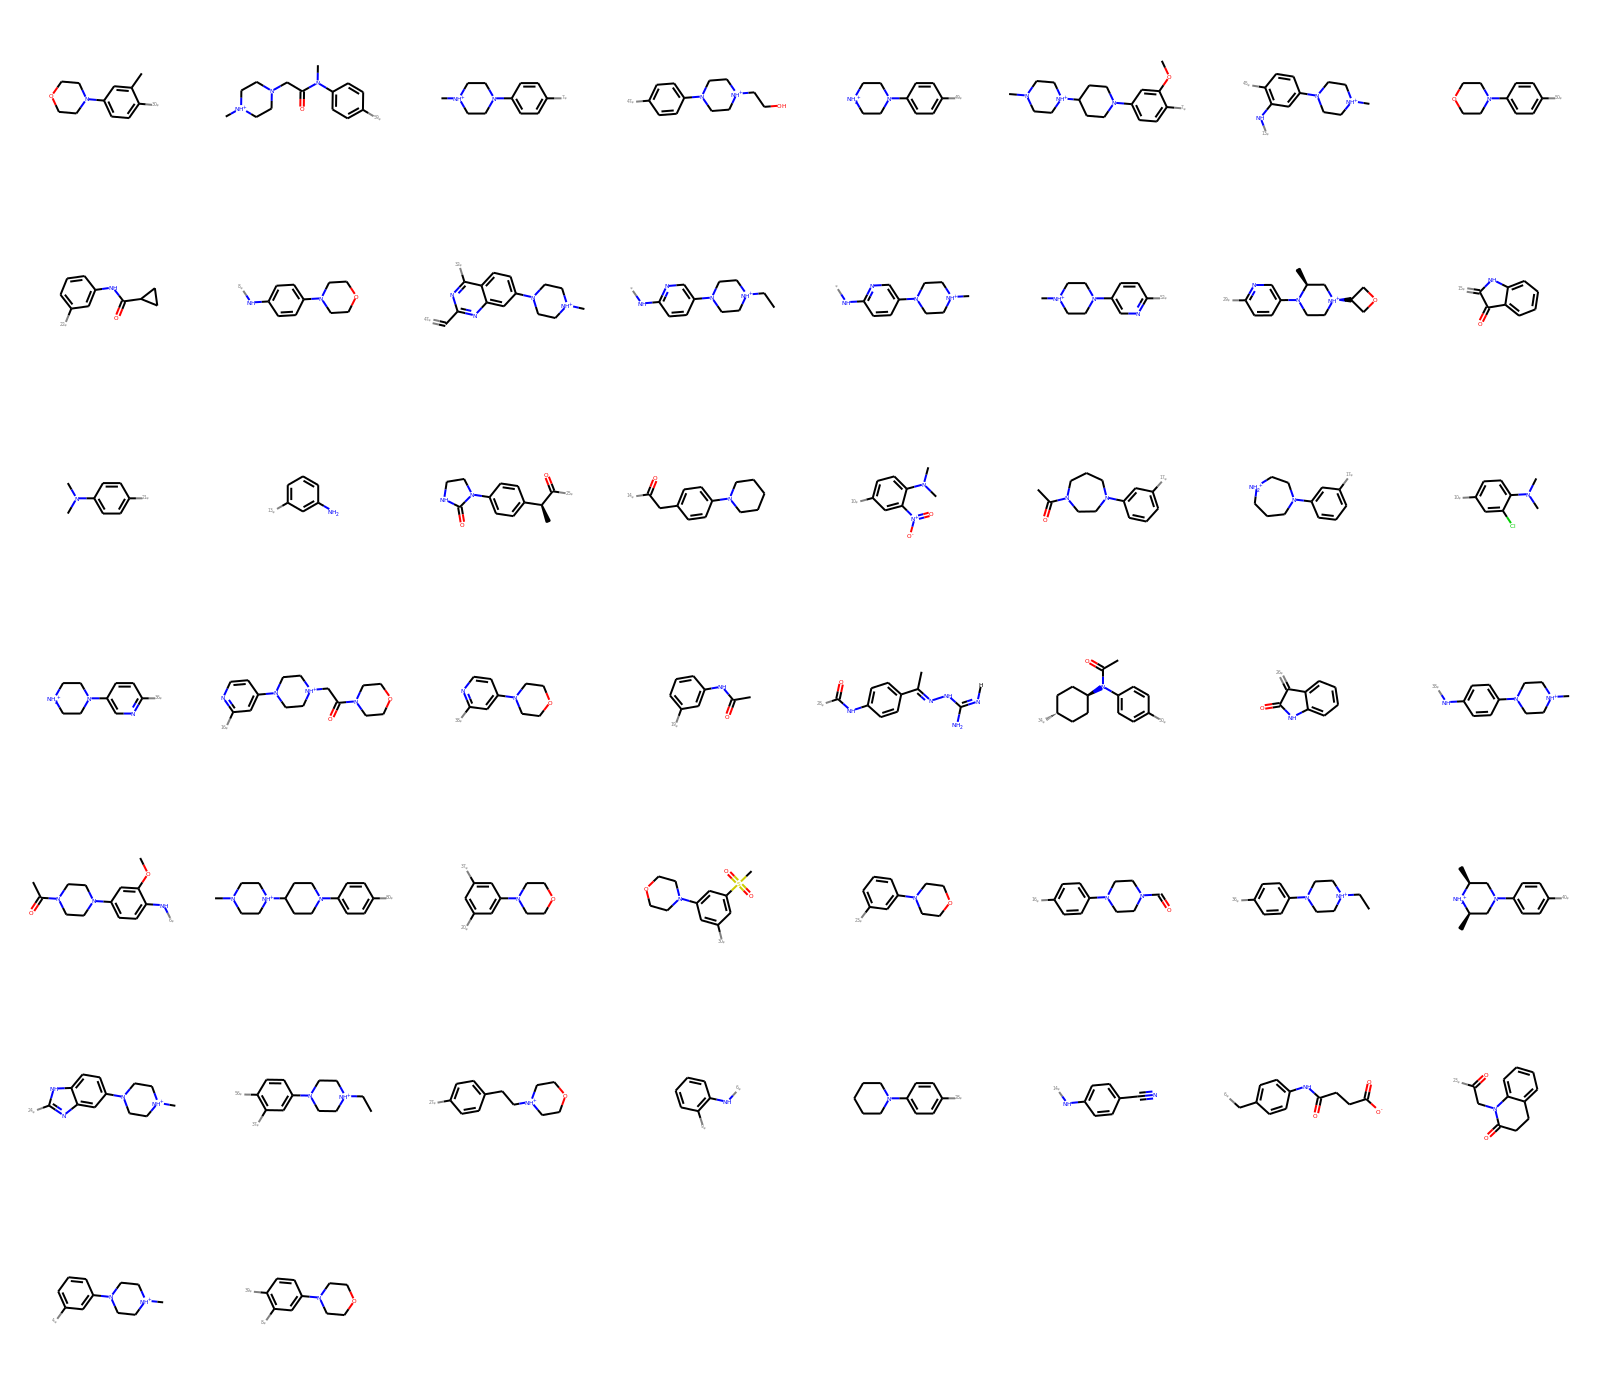

In [90]:
mols = [frags[i] for i in clusters[1]]
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols],  molsPerRow=8)

Cluster representatives: 


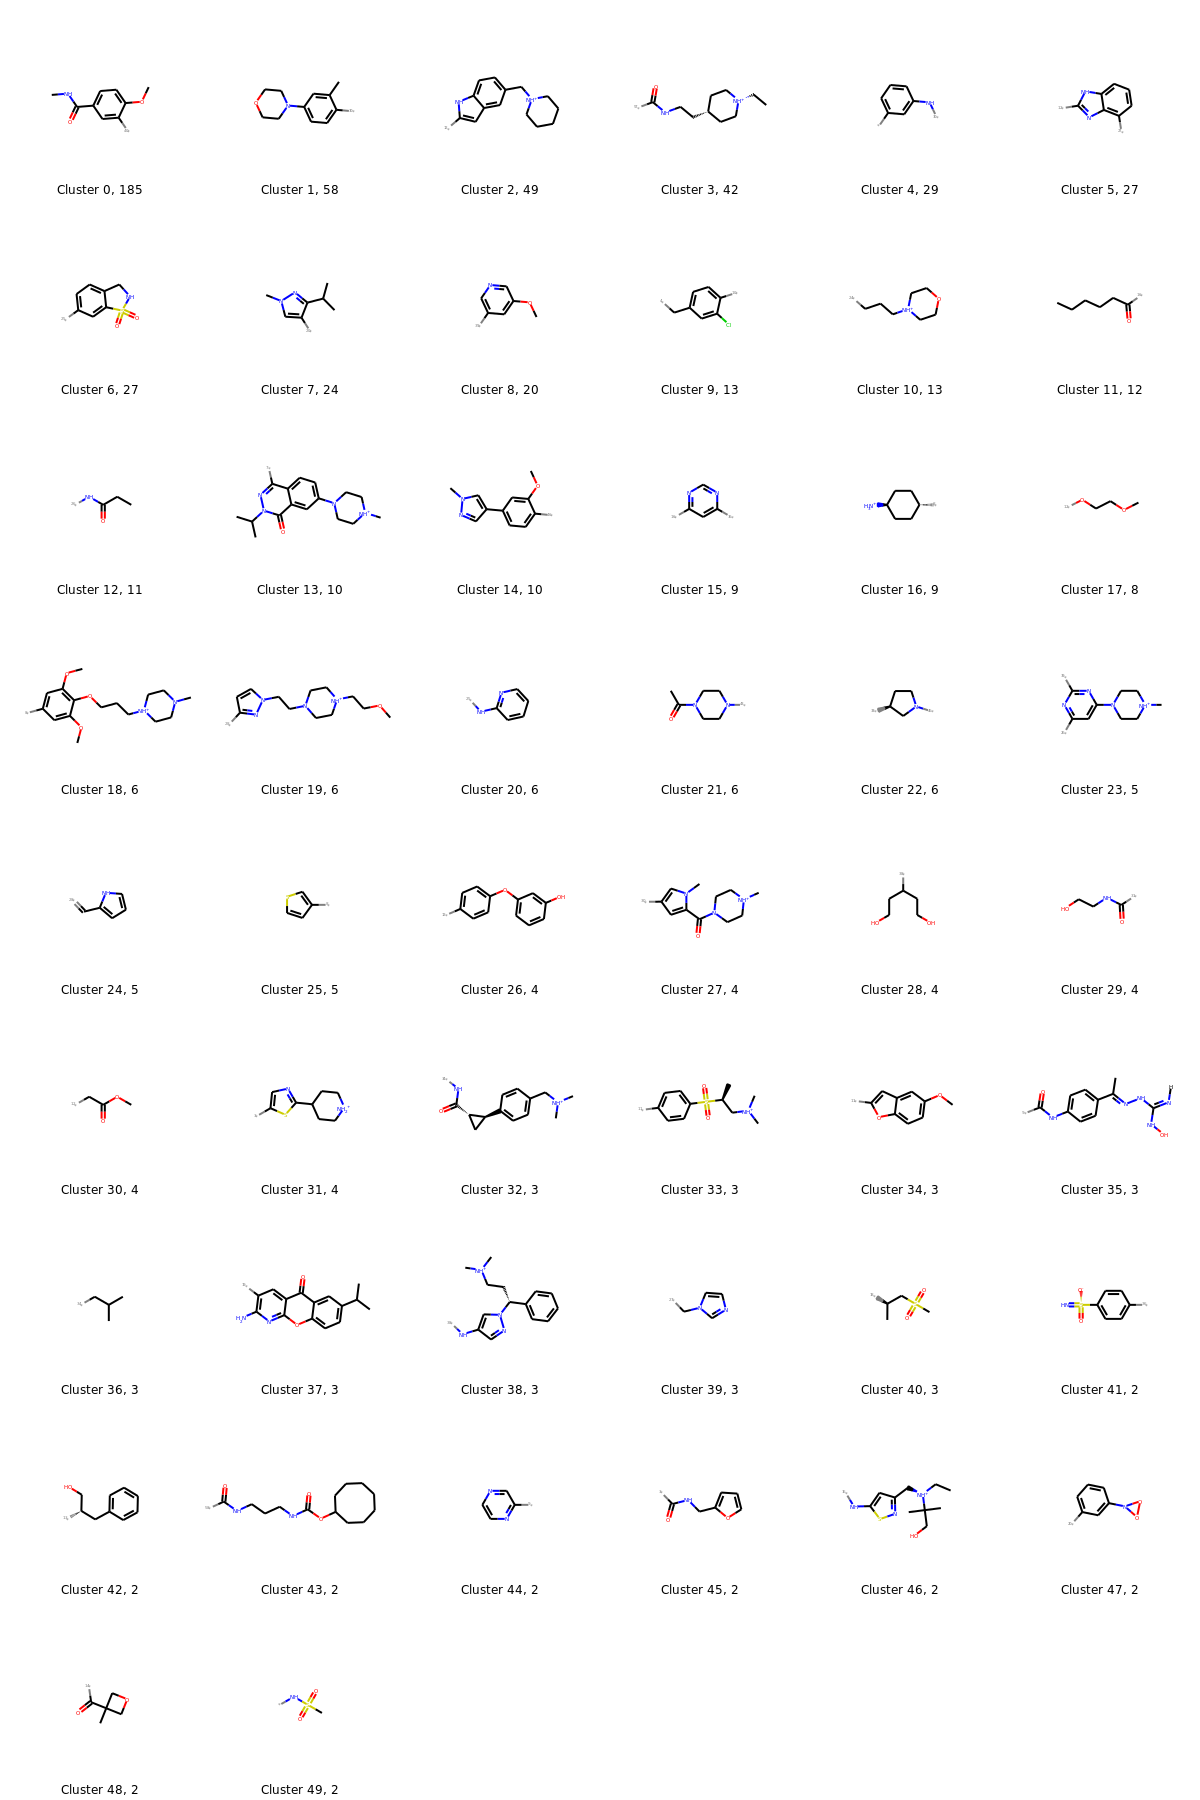

In [91]:
mols = []
legends = []
# plot cluster centroid for largest clusters
for i, cluster in enumerate(clusters):
    fragments = [frags[i] for i in cluster]
    # fragments.sort(key=mol_size)  # choose smallest fragment instead of centroid
    mols.append(fragments[0])
    legend = 'Cluster '+str(i)+', '+str(len(cluster))
    legends.append(legend)
               
with open(path_to_library+'/SE/SE_reduced_'+str(cutoff)+'.sdf', 'w')as out_file:
    w = Chem.SDWriter(out_file)
    for mol in mols:
        w.write(mol)
    w.close()
    
print('Cluster representatives: ')     
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols], legends=legends, molsPerRow=6)

### Gate area:

GA
Threshold:  0.7
total # clusters:  87
# clusters with only 1 compound:  45
# clusters with >5 compounds:  18
# clusters with >25 compounds:  4
# clusters with >100 compounds:  1


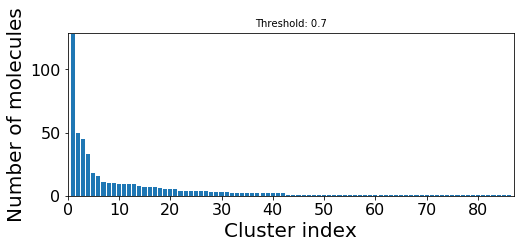

Total number of fragments:  510


In [92]:
# investigate adenine pocket clusters
fps = df_GA.fingerprint
frags = list(df_GA.Mol)

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
analyze_clusters(clusters, 'GA', cutoff)

print('Total number of fragments: ', len(frags))

Cluster representatives: 


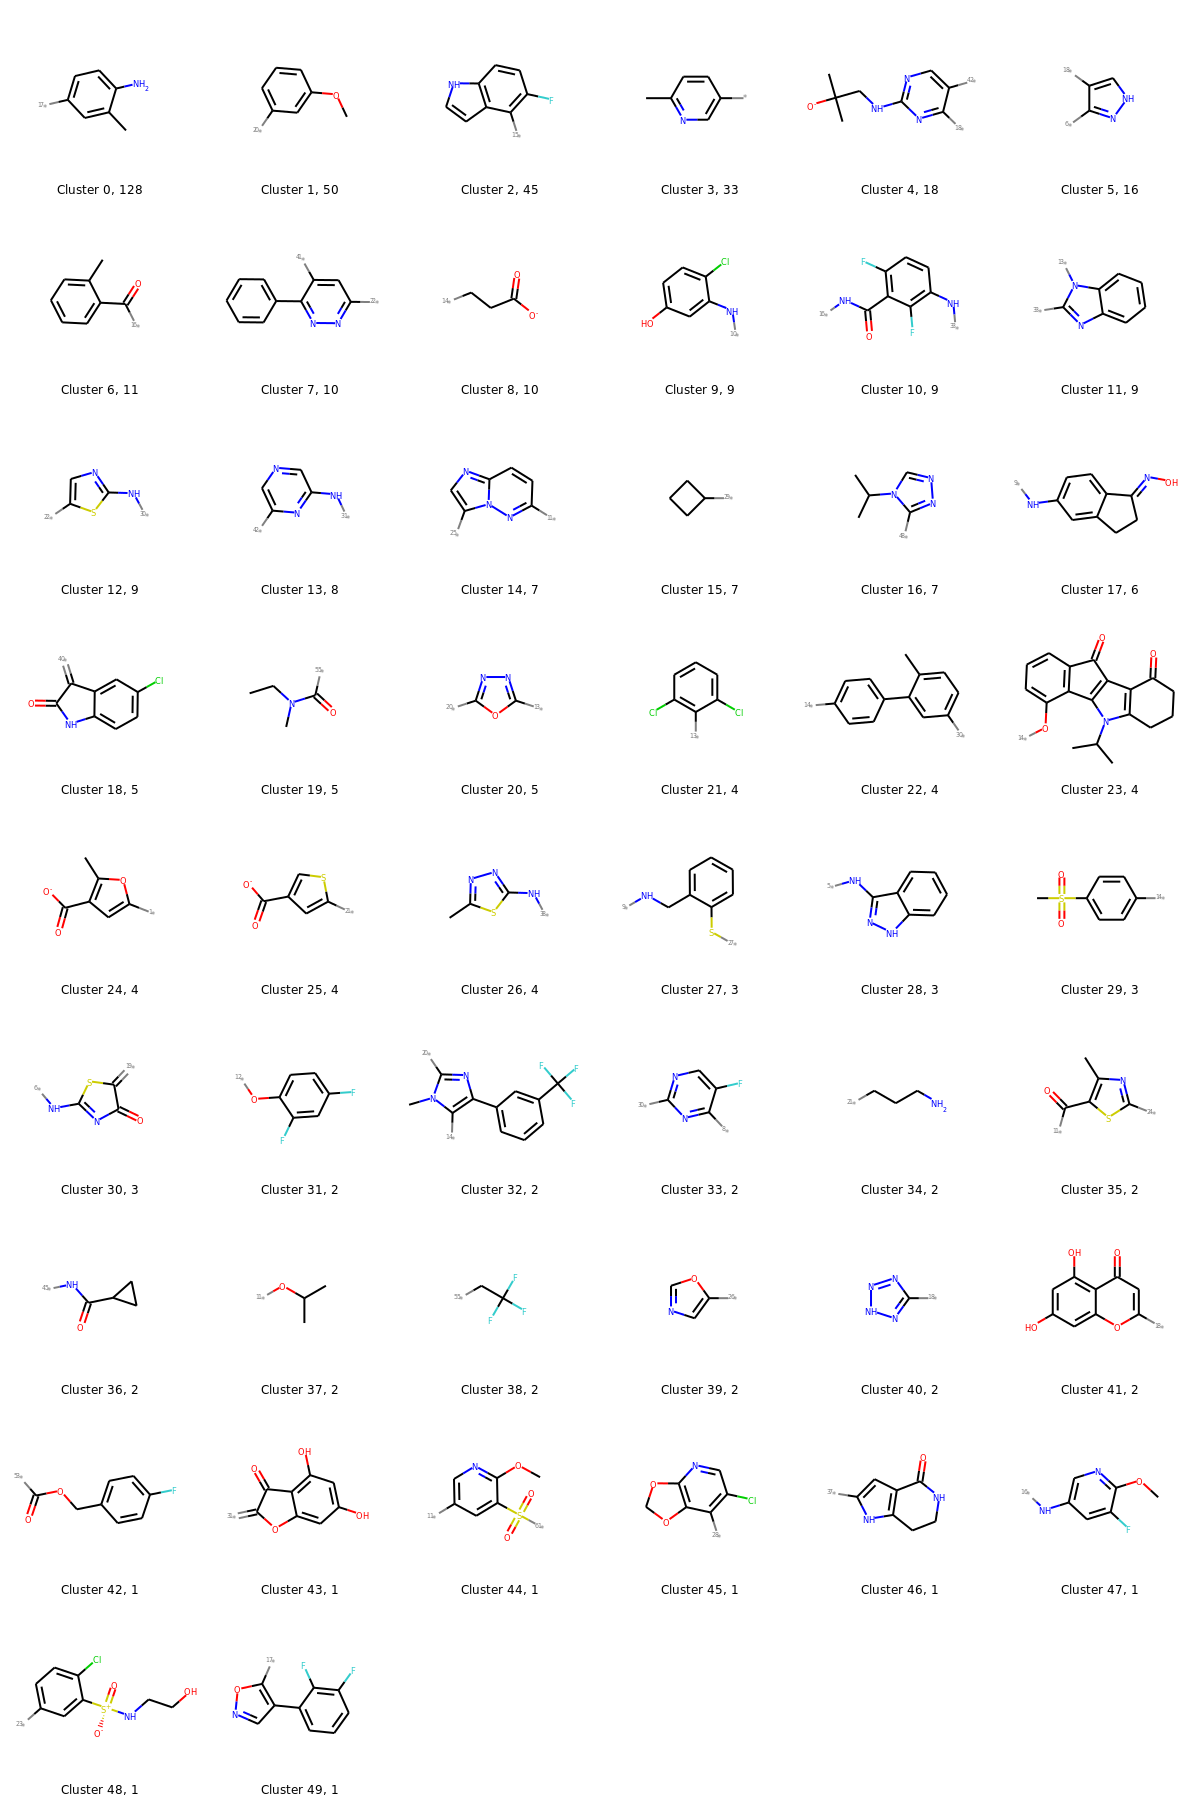

In [93]:
mols = []
legends = []
# plot cluster centroid for largest clusters
for i, cluster in enumerate(clusters):
    fragments = [frags[i] for i in cluster]
    # fragments.sort(key=mol_size)  # choose smallest fragment instead of centroid
    mols.append(fragments[0])
    legend = 'Cluster '+str(i)+', '+str(len(cluster))
    legends.append(legend)
               
with open(path_to_library+'/GA/GA_reduced_'+str(cutoff)+'.sdf', 'w')as out_file:
    w = Chem.SDWriter(out_file)
    for mol in mols:
        w.write(mol)
    w.close()
  
print('Cluster representatives: ') 
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols], legends=legends, molsPerRow=6)

### Back pocket I:

B1
Threshold:  0.7
total # clusters:  22
# clusters with only 1 compound:  13
# clusters with >5 compounds:  3
# clusters with >25 compounds:  0
# clusters with >100 compounds:  0


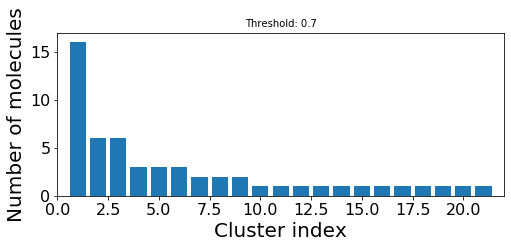

Total number of fragments:  56


In [94]:
# investigate adenine pocket clusters
fps = df_B1.fingerprint
frags = list(df_B1.Mol)

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
analyze_clusters(clusters, 'B1', cutoff)

print('Total number of fragments: ', len(frags))

Cluster representatives: 


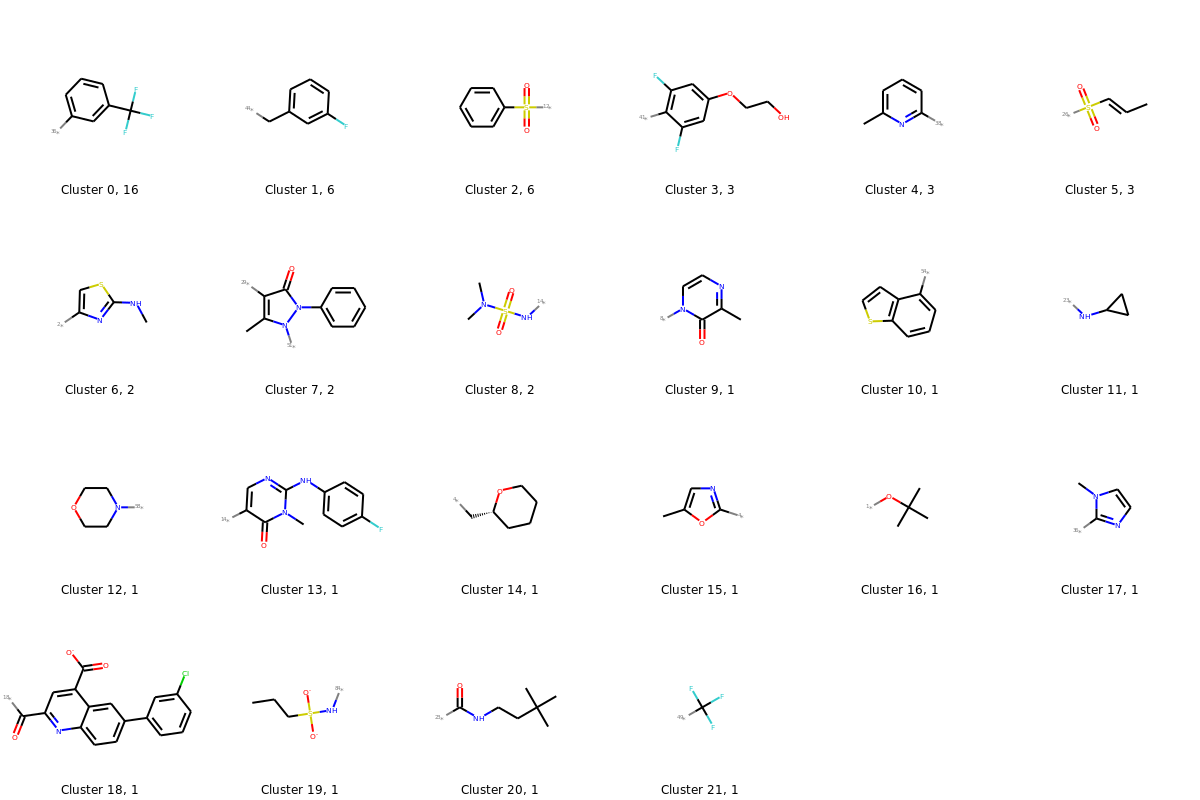

In [95]:
mols = []
legends = []
# plot cluster centroid for largest clusters
for i, cluster in enumerate(clusters):
    fragments = [frags[i] for i in cluster]
    # fragments.sort(key=mol_size)  # choose smallest fragment instead of centroid
    mols.append(fragments[0])
    legend = 'Cluster '+str(i)+', '+str(len(cluster))
    legends.append(legend)
                
with open(path_to_library+'/B1/B1_reduced_'+str(cutoff)+'.sdf', 'w')as out_file:
    w = Chem.SDWriter(out_file)
    for mol in mols:
        w.write(mol)
    w.close()
    
print('Cluster representatives: ')    
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols], legends=legends, molsPerRow=6)

### Back pocket II:

B2
Threshold:  0.7
total # clusters:  39
# clusters with only 1 compound:  22
# clusters with >5 compounds:  4
# clusters with >25 compounds:  1
# clusters with >100 compounds:  0


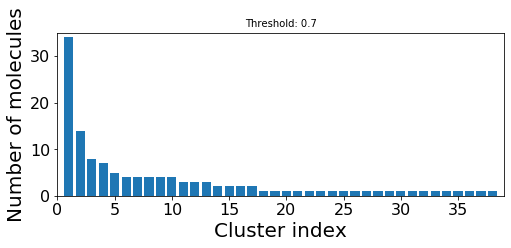

Total number of fragments:  127


In [96]:
# investigate adenine pocket clusters
fps = df_B2.fingerprint
frags = list(df_B2.Mol)

clusters = ClusterFps(fps, cutoff=cutoff)
# sort clusters by size
clusters = sorted(clusters, key=len, reverse=True)
 
analyze_clusters(clusters, 'B2', cutoff)

print('Total number of fragments: ', len(frags))

Cluster representatives: 


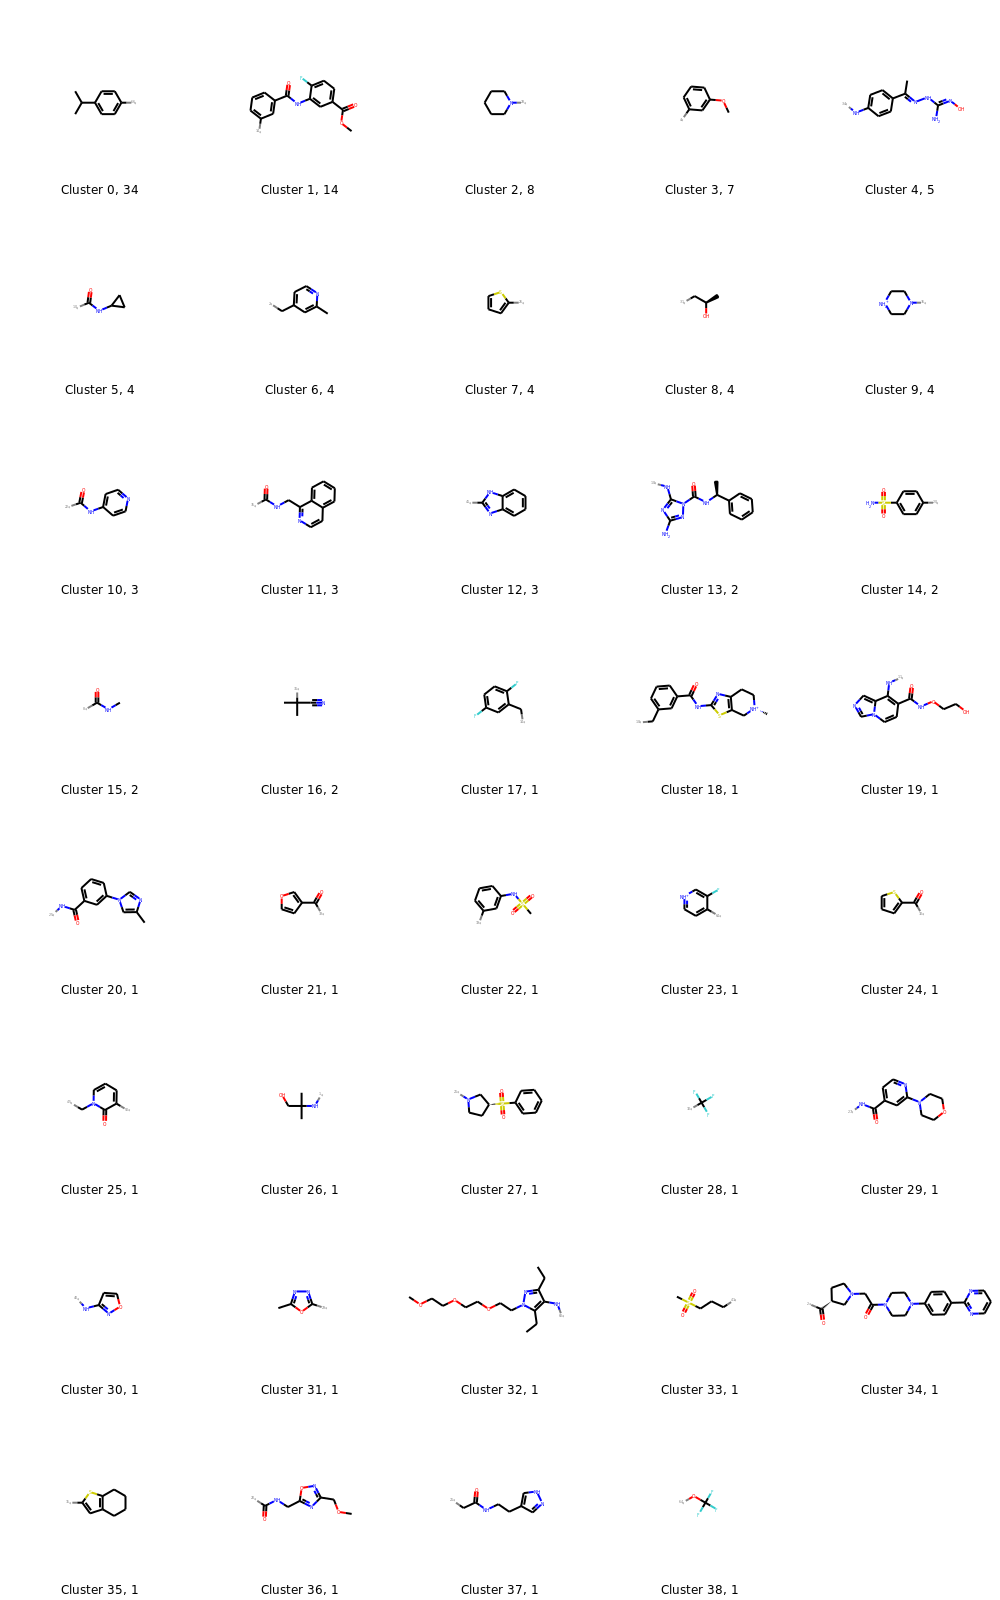

In [97]:
mols = []
legends = []
# plot cluster centroid for largest clusters
for i, cluster in enumerate(clusters):
    fragments = [frags[i] for i in cluster]
    # fragments.sort(key=mol_size)  # choose smallest fragment instead of centroid
    mols.append(fragments[0])
    legend = 'Cluster '+str(i)+', '+str(len(cluster))
    legends.append(legend)
               
with open(path_to_library+'/B2/B2_reduced_'+str(cutoff)+'.sdf', 'w')as out_file:
    w = Chem.SDWriter(out_file)
    for mol in mols:
        w.write(mol)
    w.close()

print('Cluster representatives: ') 
Draw.MolsToGridImage([Chem.MolFromSmiles(Chem.MolToSmiles(mol)) for mol in mols], legends=legends, molsPerRow=5)